# **Fine Tune a Vision Transformer for Image Classification with LoRA**


In this notebook we'll explore how to fine-tune a **Vision Transformer (ViT)** model efficiently using **Low-Rank Adaptation (LoRA)**. The goal is to adapt a pretrained image classification model to recognize new classes from a small dataset without requiring **massive compute resources** from training entirely new parameters. The process is also optimized for CPU so basically any machine can run this lab.

## What Are Vision Transformers (ViTs)?
Vision Transformers (ViTs) are a type of deep learning model that apply the **transformer architecture** to computer vision tasks **(segmentation, classification, detection)**. Instead of scanning images with convolutional filters (like CNNs), ViTs **split an image into small patches**, flatten them into vectors (tokens), and feed those tokens into a transformer encoder.

Each token represents a region of the image, and **self-attention** layers allow the model to learn how different parts of the image relate to each other. 

This global attention mechanism often leads to better context understanding compared to local convolutions.

**Key ideas behind ViTs:**
- Images are divided into fixed-size patches (e.g., 16×16 pixels).
- Each patch is embedded into a vector (a "token").
- The transformer encoder processes all tokens simultaneously with multi-head self-attention.
- The output is used for classification, detection, or other downstream tasks.


## Why Fine-Tune Vision Transformers?
Pretrained vision transformers are trained on massive datasets (such as ImageNet).  
Fine-tuning lets us **adapt** this general knowledge to a new, smaller dataset, allowing it to identify a specific subject.

Fine-tuning updates model weights slightly so that it learns to specialize without starting from scratch.  
However, ViTs have **millions of parameters**, which can be slow or memory-intensive to train fully, especially on CPUs (this environment). This is why we'll use Low Rank Adapters to fine tune the model.

Inside a transformer, the **weights** that the model learns are stored in large **matrices**: grids of numbers that define how inputs are transformed into outputs. Updating all of these matrices during fine-tuning requires significant memory and compute.  

By understanding that these weight matrices hold the model’s learned patterns, we can see how **LoRA** cleverly modifies only a *small portion* of them instead of the entire network.


## What Is LoRA (Low-Rank Adaptation)?

**At a high-level:**
- **LoRA** is a **parameter-efficient fine-tuning (PEFT)** method that drastically reduces memory and compute needs.
- Instead of updating all model weights, LoRA inserts small **trainable adapters** inside the attention layers.
- These adapters learn low-rank updates to the original weights, while the base model remains frozen.
- Simply put, we use **structures** (adapters) with less parameters to make updates to large matrices with many parameters.

**Conceptually:**
- Original weight matrix `W` → decomposed into `W + A·B`, where `A` and `B` are small, trainable low-rank matrices.
- Only `A` and `B` are trained, often <1% of the total parameters.
- If `W` is a matrix of `d x d` parameters, `A` and `B` are two, **much smaller** matrices that multiply to a `d x d` matrix so they can *update* `W`.
    - We will get into how they work at a lower level later.
- The model learns efficiently with little risk of overfitting.

**Advantages:**
- **Time**: Faster training (fewer trainable parameters).  
- **Space**: Lower memory usage (ideal for limited hardware).  
- **Modularity**: Easy to swap adapters to switch tasks (without retraining the base model).

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/0CHXduhqOiFHEX-JEeRwfQ/lora.png" />


## Why This Approach Works
By combining the **representational power of pretrained ViTs** with the **efficiency of LoRA**, we achieve the best of both worlds:
- **Transfer** the general image understanding learned from large datasets.
- **Efficiently** adapt to new, small datasets with minimal compute cost.


## Objectives

In this project you will:
- **Walkthrough the simple process of LoRA** in PyTorch.
- **Load a pretrained Vision Transformer** (`DeiT Tiny` (5 million parameters).
- **Load a dataset** of our subject and attach the label to each image.
- **Extend the classifier head** to include our new class we want the model to be able to detect.
- **Freeze all base model weights** so only the adapter layers are trained.
- **Add LoRA adapters** to the attention projections (`query` and `value`).
- **Fine-tune** on our small dataset using the Hugging Face `Trainer` module.
- **Evaluate** the model on new images to measure its specialized performance.


## Setup
For this lab, we will be using the following libraries:

* `torch`: (PyTorch) library for building and training deep learning models.
* `transformers`: (HuggingFace) library that provides pretrained transformer architectures and tools for model fine-tuning.
* `datasets`: (HuggingFace) library for loading, processing, and managing datasets efficiently.
* `peft`: (HuggingFace) Parameter-Efficient Fine-Tuning library that enables lightweight fine-tuning methods such as LoRA for large models.
* `pillow`: Python Imaging Library (PIL) used for loading and manipulating image files.


### Installing Required Libraries

Run the following cell to install all the necessary dependencies (**might take up to 10 minutes**):


In [1]:
%%capture
!pip install torch==2.9.0 --index-url "https://download.pytorch.org/whl/cpu"
!pip install transformers==4.57.1
!pip install datasets==3.6.0
!pip install peft==0.17.1
!pip install pillow==12.0.0 
!pip install matplotlib==3.10.7

## Principles of Training

**If you understand gradient descent and loss functions, feel free to skip this section.**

Before we do anything with LoRA or ViTs, let's take a minute to understand how parameters are trained at a high-level.

First we define the function:
$$
\hat{y} = F(x \mid W)
$$

Where **x** is an input image and **W** is a set of parameters. The function $F$ might be a transformer or a neural network, the architectural details don't matter for now.

When classifying an image, let's use image $x_1$:  
$$
F(x_1 \mid W_1) = \text{"raccoon"}
$$


However, for a second image $x_2$, which *is* also a raccoon, the model might output:
$$
F(x_2 \mid W_1) = \text{"badger"}
$$


This is a misclassification. Our goal is to adjust (train) the parameters so that the model makes fewer mistakes. After updating the weights to a new set $W_2$, we hope that:
$$
\text{"raccoon"} = F(x_1 \mid W_2) \quad and \quad \text{"raccoon"} = F(x_2 \mid W_2)
$$

The increased accuracy means less error and loss in our model.

To increase accuracy and reduce error, we need to define a **loss function** that measures how "wrong" the classifier model is. 

$$
L(y, \hat{y}(W))
$$

This is the general form of a loss function:
- $L$ is the loss function itself.
- $y$ is the true target, the correct class.
- $\hat{y}(W)$ is the model's predicted class as a function of the model's parameters, $W$.

Training means finding the value of $W$ that **minimizes** this loss. The real math can get heavy, so here is a simple loss function example:
$$
L(w) = (w - 2)^2
$$

**Gradient descent** updates parameters by stepping in the direction that lowers the loss:
$$
w_{k+1} = w_k - \eta \frac{dL}{dw}
$$

This is made possible because the loss function is a function of the model parameters, hence we can use a little bit of **calculus 1** and **chain rule** to find the **gradient** (derivative) of the loss and update the parameters in a direction according to that gradient.


This ideally results in:

$L(w_0) > L(w_1) > L(w_2)$

In practice, real loss functions are far more complex, and the loss does not always decrease every step. In practice, $W$ is not a single number—it is a vector, a matrix, or even thousands of matrices. The goal of this lab is to show how we can minimize $L(y, \hat{y}(W))$ without manually adjusting every value in $W$.


## Simplified LoRA Process

Before we get into fine tuning the actual vision model, let's go through the LoRA process with small matrices and simple matrix operations. You should have a basic knowledge of linear algebra and matrix manipulation for this.

### Seed configuration

Run the following cell to set the PyTorch seed so you'll get consistent results in the LoRA process visualization.


In [66]:
import torch
torch.manual_seed(42)

import random
random.seed(42)

import numpy as np
np.random.seed(42)

Let's start off with a base **weight matrix**, W. There exists many learnable weight matrices that store up to millions of values in a grid pattern. For this demo we'll work with a 5 x 6 (rows x columns) matrix with 30 *randomly* generated entries. If you set the `manual_seed`, you'll see the same matrix generated while the seed remains the same.


In [4]:
in_features = 6
out_features = 5

W = torch.randn(out_features, in_features)
W

tensor([[ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784, -1.2345],
        [-0.0431, -1.6047, -0.7521,  1.6487, -0.3925, -1.4036],
        [-0.7279, -0.5594, -2.3169, -0.2168, -1.3847, -0.8712],
        [-0.2234,  1.7174,  0.3189, -0.4245, -0.8286,  0.3309],
        [-1.5576,  0.9956, -0.8798, -0.6011, -1.2742,  2.1228]])

The matrix `W` represents a linear transformation that maps an input vector of size `in_features` to an output vector of size `out_features`. In PyTorch we can demonstrate this by defining an input vector `x` and multiplying it by `W`:


In [5]:
x = torch.randn(in_features)
print("x:", x)

y = W @ x
print("y:", y)

x: tensor([-0.0915,  0.2352,  2.2440,  0.5817,  0.4528,  0.6410])
y: tensor([ 0.4857, -2.1796, -6.5756,  0.7299, -1.1634])


You can also take the **transpose** of `W` and multiply by `x`, it should output the same vector as `y`.


In [6]:
x @ W.T

tensor([ 0.4857, -2.1796, -6.5756,  0.7299, -1.1634])

The purpose of **fine-tuning** is to make updates to `W` such that the output `y`, when applying the transformation `W` to `x`, is optimal for a given use case. In this case we could just update every parameter in `W`, after all it's only 30 values.

If we wanted to add 1 to each parameter we could simply do:


In [7]:
W_update = torch.ones(out_features, in_features)
print("W_update:", W_update)

W_updated = W + W_update
print("W_updated:", W_updated)

W_update: tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])
W_updated: tensor([[ 2.9269,  2.4873,  1.9007, -1.1055,  1.6784, -0.2345],
        [ 0.9569, -0.6047,  0.2479,  2.6487,  0.6075, -0.4036],
        [ 0.2721,  0.4406, -1.3169,  0.7832, -0.3847,  0.1288],
        [ 0.7766,  2.7174,  1.3189,  0.5755,  0.1714,  1.3309],
        [-0.5576,  1.9956,  0.1202,  0.3989, -0.2742,  3.1228]])


The main idea of LoRA is that we don't change the big weight matrix $W$. Instead, we learn a small update called $ \Delta W$. This update is much smaller than $W$, so it's faster and cheaper to train. 

Next, we will show how we can get a super small $BA$. It's not exactly as good as training $W$, but it's pretty close.


In large transformer models, where `W` can contain millions or even billions of parameters, updating all of them is computationally expensive and memory-intensive.

**Low-Rank Adapters** can make updates to these huge matrices while being much, much smaller (<1% of originalparameters).

$$
W' = W + \frac{\alpha}{r} \cdot \Delta W \\\\\\\\\\\\\\\\\\ ;
\quad \Delta W = A B
$$

- $W'$ is the updated weights
- $W$ is the original base weights
- $\Delta W$ is a matrix with the same dimensions $W$ that updates it
- $\frac{\alpha}{r}$ scales the impact of $\Delta W$
- $A$ and $B$ are the learnable **Low-Rank Adapters** that multiply to become $\Delta W$

We’ll skip the detailed math behind how the LoRA update formula is derived. See [**LoRA: Low-Rank Adaptation of Large Language Models (Hu et al., 2021)**](https://arxiv.org/abs/2106.09685) for the full explanation.

Before we create our LoRA (low-rank adapters) and use them to update `W`, we must discuss the key **hyperparameters**.


In [8]:
rank = 2
alpha = 1.0

### LoRA Hyperparameters

LoRA introduces a few key hyperparameters that control how much capacity and influence the adapter has on the base model. There are other hyperparameters but these are the only two that must be configured.

### Rank (`rank` or r)
The rank determines the dimensionality of the low-rank update matrices, `A` and `B`. It controls how much expressive capacity the adapter has.
- Low ranks (e.g. 4–8) → smaller, faster adapters, good for similar or simple tasks
- Higher ranks (e.g. 32–64) → more capacity, useful for larger domain shifts
- Parameter cost grows roughly linearly with rank
- Mathematically, rank, is the number of linearly independent rows or columns in a matrix.

### Alpha (`alpha` or α)
The scaling factor that adjusts the strength of the LoRA update. It scales the low-rank matrix (`AB`) before adding it to the frozen weight.
- Larger α → LoRA updates have more influence
- Smaller α → more conservative, stable updates
- Often set such that `alpha` / `rank` remains roughly constant across different ranks.
    - `α′ = α / r` keeps the update scale roughly constant regardless of `r`
    - e.g., `rank` = 2, `alpha` = 4, `alpha` / `rank` = 2 so when `rank` = 4, `alpha` = 8, `alpha` / `rank` = 2
 
Now that we have our key hyperparameters, we can create our $A$ and $B$ low-rank adapters.


In [9]:
A = torch.randn(out_features, rank) * 0.1
B = torch.randn(rank, in_features) * 0.1

print("A:", A)
print("B:", B)

A: tensor([[ 0.0520,  0.0557],
        [ 0.0074,  0.0711],
        [-0.0569,  0.1258],
        [-0.1589, -0.1121],
        [ 0.0842,  0.0174]])
B: tensor([[-0.2126,  0.0963,  0.0760,  0.0734, -0.0671,  0.2742],
        [ 0.0557, -0.0812,  0.1196,  0.0861, -0.1368, -0.0774]])


For this demonstration, we'll use randomly generated values as the final adapters. In actual LoRA fine-tuning, the adapters are **randomly initialized** and then updated via [gradient descent](https://www.ibm.com/think/topics/gradient-descent?utm_source=skills_network&utm_content=in_lab_content_link&utm_id=Lab-Fine+Tune+DeiT+Tiny-v1_1762889552). Again, the primary difference to **full-parameter** fine-tuning is that fact that low-rank adapters have **less weights** and therefore requires **less compute and space** to update.

The $\Delta W$ is simply a matrix multiplication between the adapters ($AB$). This matrix has the same dimensions as the full $W$ matrix so it can be directly added.

**This lab will NOT go into gradient descent as it is a large topic separate (but related) from LoRA fine-tuning. Feel free to learn about gradient descent through other guided projects on [Cognitive Class](https://cognitiveclass.ai/)**


In [10]:
W_delta = A @ B
print("W_delta:", W_delta)

W_delta: tensor([[-0.0080,  0.0005,  0.0106,  0.0086, -0.0111,  0.0099],
        [ 0.0024, -0.0051,  0.0091,  0.0067, -0.0102, -0.0035],
        [ 0.0191, -0.0157,  0.0107,  0.0067, -0.0134, -0.0253],
        [ 0.0275, -0.0062, -0.0255, -0.0213,  0.0260, -0.0349],
        [-0.0169,  0.0067,  0.0085,  0.0077, -0.0080,  0.0217]])


Before adding the adapter matrix (`W_delta`), we scale it by $\frac{\alpha}{r}$. This scaling is implemented because as you increase `rank`, the adapters gain capacity. This increase in capacity causes the values in $AB$ to have a larger magnitude. 

Therefore, scaling by a factor of `1 / rank` keeps the **effect of rank balanced**. Mathematically, this means we take the average of each `rank` and scale `W_delta` by it. Finally, scaling by `alpha` gives you a control knob to the overall influence of the LoRA.


In [11]:
W_lora = W + (alpha / rank) * W_delta
print("W_lora:", W_lora)

W_lora: tensor([[ 1.9229,  1.4875,  0.9060, -2.1012,  0.6729, -1.2296],
        [-0.0419, -1.6072, -0.7476,  1.6521, -0.3976, -1.4053],
        [-0.7183, -0.5673, -2.3116, -0.2135, -1.3914, -0.8839],
        [-0.2096,  1.7143,  0.3061, -0.4352, -0.8156,  0.3135],
        [-1.5660,  0.9990, -0.8755, -0.5973, -1.2782,  2.1337]])


The final `W_lora` ($W'$) matrix is the updated weights that took the time and compute of updating $A$ and $B$ to fine-tune. As mentioned previously, in transformers, the weights of $A$ and $B$ are often less than 1% of the weights of $W$, saving massive compute and space.

Let's see a side-by-side comparison of the `y` output after training (`y_lora`) with before training (`y_base`).


In [12]:
y_lora = W_lora @ x

print("y_lora:", y_lora)
print("y_base:", y)

y_lora: tensor([ 0.5012, -2.1717, -6.5755,  0.6879, -1.1449])
y_base: tensor([ 0.4857, -2.1796, -6.5756,  0.7299, -1.1634])


The tensors are similar, but there are **small changes** resulting from the LoRA adapter update.


# Fine-tuning a Vision Transformer (ViT)

Now that we have a low-level understanding of how LoRA works, let's use it to fine-tune a **vision transformer** on an image dataset of raccoons for **classification**.


## Setup

Import all dependencies with the following code cell.


In [ ]:
# Import the feature extractor and vision model modules from Hugging Face
from transformers import ViTImageProcessor, ViTForImageClassification
# Import PIL for image loading and manipulation (e.g., resizing, opening JPEG/PNG)
from PIL import Image
# Load standard or custom datasets conveniently (e.g., from Hugging Face Hub or local files)
from datasets import load_dataset, Dataset
# Core PyTorch modules for building and using neural networks
import torch.nn as nn
import torch.nn.functional as F
# OS module for file and directory operations (e.g., saving model checkpoints, logs)
import os

# LoraConfig sets LoRA hyperparameters, and get_peft_model wraps a model for efficient fine-tuning
from peft import LoraConfig, get_peft_model
# Import classes for defining training configurations and managing the training loop with Hugging Face Trainer API
from transformers import TrainingArguments, Trainer

## Fetch and Split Dataset

**Add you own dataset if you want to fine-tune your own DeiT.**


Next we'll fetch a dataset of 75 images of raccoons from a Github repository.
- Best practice is to include a small number of images from other, visually related classes to provide contrastive supervision and prevent overconfidence toward the newly added label.
- For this demo lab, we'll just stick to using a homogenous dataset.

In [14]:
!git clone --branch trimmed --single-branch https://github.com/joshuazhou744/raccoon_dataset.git

Cloning into 'raccoon_dataset'...
remote: Enumerating objects: 660, done.
remote: Counting objects: 100% (660/660), done.
remote: Compressing objects: 100% (241/241), done.
remote: Total 660 (delta 420), reused 653 (delta 417), pack-reused 0 (from 0)
Receiving objects: 100% (660/660), 48.01 MiB | 41.91 MiB/s, done.
Resolving deltas: 100% (420/420), done.


Let's extract the image file names into a list called `image_files`.
We'll also shuffle the order of our images so our train and test sets are representative.

In [43]:
dataset_dir = "./raccoon_dataset/images"
image_files = [
    os.path.join(dataset_dir, f)
    for f in os.listdir(dataset_dir)
    if f.lower().endswith("jpg")
]

random.shuffle(image_files)

We'll manually create a **train-test split** with two different lists. The `train_files` will have 65 images while the `test_files` will contain the remaining 10.


In [44]:
train_files = image_files[:65]
test_files = image_files[65:]

A train-test split is a common method of **cross-validation** to evaluate the output of a model on unseen test data after training on the train data.

Let's create a helper function, `load_images`, to convert each image file into a PIL (Python Imaging Library) Image that can be stored in a HuggingFace `Dataset` object.


In [45]:
def load_images(file_paths):
    return {"image": [Image.open(f).convert("RGB") for f in file_paths]}

We'll use the `Dataset.from_dict` method to convert each `load_images` dictionary to a `Dataset` object. Notice that we leave our datasets **unlabeled**, this is because all images in our dataset have the **same label**.

Since every training example shares the same label, there’s no need to assign it individually during image loading. Instead, we’ll attach the label later in one step using the `Dataset.map()` method, after the model configuration is updated with our new class label. This ensures that the numeric label ID we assign matches the model’s internal label mapping. This will make sense in a bit.


In [46]:
train_dataset = Dataset.from_dict(load_images(train_files))
test_dataset = Dataset.from_dict(load_images(test_files))

Let's take a look at one of our images.


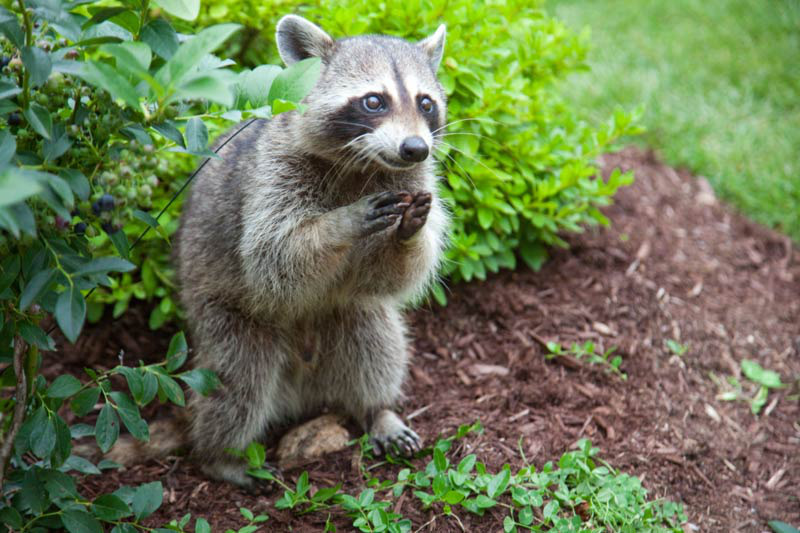

In [49]:
train_dataset[0]['image']

## Vision Transformer

For this project, we'll fine-tune a Data-efficient Image Transformer (DeiT) Tiny model with around **5 million parameters**. Compared to LLMs (billions of parameters), this is a miniscule amount. As such, the less overall parameters in a vision transformer make it viable to fine-tune in an environment without a GPU (this environment, which runs on CPU on a Cloud Container and is displayed to you here).

The model ID on HuggingFace is `facebook/deit-tiny-patch16-224`.
- The model was trained on the **ImageNet-1k dataset** (1 million images, 1,000 classes).
- The model trains and infers on **224x224 pixel** images, all images are resized to this resolution before handled.
- Each image is divided into **16x16 patches** (each patch is 14x14 pixels), which are interpreted as input tokens by the transformer.


In [50]:
extractor = ViTImageProcessor.from_pretrained("facebook/deit-tiny-patch16-224")
base_model = ViTForImageClassification.from_pretrained("facebook/deit-tiny-patch16-224")

### Update the Classification Layer

Before any fine-tuning, we have to update the labels the model recognizes. As mentioned above, the base vision model can detect 1,000 classes, so we'll have to add a **raccoon** class and make that 1,001 classes.

We'll have to update the **linear classifier head** and the configuration dictionaries (`id2label` and `label2id`).


In [51]:
# define old linear head and it's number of input features
old_head = base_model.classifier
in_features = old_head.in_features

In [52]:
old_head

Linear(in_features=192, out_features=1000, bias=True)

In [53]:
in_features

192

Let's update the **Classifier Head** that maps output feature vectors into probabilities for each class.
- First we get `old_head`, a `Linear` layer that maps feature vectors to logits (probabilities).
- For DeiT, `in_features` or the length of the feature vector per batch is 192, and there are 1,000 logits as output for the base classifier head (`old_head`)
    - Logits can be interpreted as "confidence scores" corresponding to a class.
    - More specifically, the classifier head is responsible for mapping a matrix of shape (`batch_size`, 192) embeddings to a matrix of shape (`batch_size`, 1,000) logits for each class per sample.
        - `batch_size` is the number of samples (images) per batch.


In [55]:
# new head
new_num_labels = old_head.out_features + 1
base_model.classifier = nn.Linear(in_features, new_num_labels)

Now we want the (linear) classifier head to be able to map to **1,001** classes (raccoon class included).

We initialized the classifier head with a new `Linear` layer shaped (`in_features`, `new_num_labels`) or (192, 1001). These values are randomly initialized.


In [56]:
base_model.classifier

Linear(in_features=192, out_features=1001, bias=True)

In [57]:
base_model.classifier.weight.shape

torch.Size([1001, 192])

In [58]:
base_model.classifier.bias.shape

torch.Size([1001])

Let's copy over the weights and biases of the original classes (first 1,000) from the `old_head`.


In [59]:
# copy old weights/biases into the first 1000 rows, initialize the last neuron (row)
with torch.no_grad():
    base_model.classifier.weight[:old_head.out_features] = old_head.weight
    base_model.classifier.bias[:old_head.out_features] = old_head.bias
    nn.init.normal_(base_model.classifier.weight[old_head.out_features:], std=0.02)
    nn.init.zeros_(base_model.classifier.bias[old_head.out_features:])

- This keeps the **original 1,000 ImageNet weights** intact so you don't lose the general vision knowledge the model already has.
- The new row (1,001st neuron) gets normalized weights with a standard deviation of 0.02 and a bias of zero.
    - This makes it so the model will learn that class from scratch during fine-tuning.
- `with torch.no_grad()` temporarily disables PyTorch gradient tracking while copying and initializing weights/biases.
    - These are manual operations that shouldn't be recorded in the **computation graph**.
    - The **computation graph** is the internal structure to track operations to a tensor so gradients can be automatically calculated during training (loss minimization).


In [60]:
base_model.classifier.weight

Parameter containing:
tensor([[ 0.0204,  0.0361,  0.0223,  ...,  0.0296, -0.0379,  0.0196],
        [ 0.0739,  0.0610,  0.0347,  ...,  0.0224,  0.0333, -0.0576],
        [-0.0228, -0.0253, -0.0077,  ...,  0.0463, -0.0239, -0.0279],
        ...,
        [-0.0213, -0.0100,  0.0026,  ..., -0.0015, -0.0284, -0.0338],
        [ 0.0075,  0.0202,  0.0496,  ..., -0.0774, -0.0049, -0.0442],
        [-0.0154,  0.0230, -0.0206,  ...,  0.0250,  0.0056,  0.0399]],
       requires_grad=True)

In [61]:
base_model.classifier.weight.shape

torch.Size([1001, 192])

In [62]:
base_model.classifier.bias

Parameter containing:
tensor([-0.2099, -0.2726, -0.2357,  ...,  0.0828,  0.3001,  0.0000],
       requires_grad=True)

In [63]:
base_model.classifier.bias.shape

torch.Size([1001])

### Interpreting the Classifier Layer

The attention layers of a transformer are complex and have multiple weight matrices to manipulate and operate on. They are not the main focus of this project so we won't get too in-depth on them. However, we will talk about the **Linear Classfication Layer** as it is crucial for mapping learned feature representations from the transformer into label/class predictions.

Mathematically, the layer performs the operation (assuming 1 sample per batch):

$$
y = xW^T + b
$$

- $x$ = input vector (shape = [`in_features`], [192])
- $W$ = weight matrix (shape = [`out_features`, `in_features`], [1001, 192])
    - Intuitively, each row of $W$ corresponds to the output features (192) of the label of row index (0-1000)
    - e.g., Row 0 $\to$ weights that determine how to detect class 0 (`id2label[0]`)
- $b$ = bias vector (shape = [`out_features`], [1001])
    - Shifts the entire output of one neuron (row), moving the **decision boundary** and allowing for **activation thresholds.**
- $y$ = logits vector (shape=[`out_features`], [1001]), a tensor of "confidence scores" for each associated label

Simply speaking, each row of $W$ shows the **learned features** of a specific class. During inference, the classification head takes the input feature vector $x$ from the transformer encoder and computes the dot product between $x$ and each class's weight vector (a row in $W$). The resulting logits $y$ measures the **similarity** of the input's features with each class's learned features, higher values mean stronger matches. We'll see how the loss function turns these logits into probabilities near the end of the project.


### Update the Label-ID Conversion

IDs are integers that correspond to a label, they are required to calculate how close the model's predicted probability distribution is to the true (one-hot) target distribution. 

For example:
- The classifier head maps the final output's features (192) -> logits (1,000, one for each label).
    - e.g., `logits = [2,3, -1.5, 0.7]` and `true_label = 0`
    - An integer class ID is required so the loss function knows which logit index corresponds to the true class during loss computation.
- **After** the classifier head outputs the logits, the loss function, `CrossEntropyLoss`, does two things to the logits:
    - Normalizes the logits into probabilities into a softmax function:
$$
p_i = \frac{e^{logit_i}}{\sum_{j}e^{logit_j}}
$$
    - Finds the probability of the correct class (`true_class`) and computes loss using **negative log-likelihood**:
$$
loss = -\log(p_{true\:class})
$$
    - Reminder: **Loss is computed after the classifier head**.


Let's update the dictionaries used to convert between label and ID in the model configuration.


In [64]:
# copy original labels
id2label = base_model.config.id2label.copy()
label2id = base_model.config.label2id.copy()

In [65]:
len(id2label)

1000

First we create a shallow copy of the model's original `id2label` and `label2id` dictionaries. This is done to avoid **mutating the model's configuration directly** since `model.config` is shared internally by many components. By copying first, we can safely modify and reassign the mappings.

After copying, you should see that there are 1,000 IDs (0-999) and labels, one for each **ImageNet-1k** class.


In [67]:
old_head.out_features

1000

In [68]:
LABEL = "raccoon"

# update config label mappings
id2label[old_head.out_features] = LABEL
label2id[LABEL] = old_head.out_features

base_model.config.num_labels = new_num_labels
base_model.config.id2label = id2label
base_model.config.label2id = label2id

Now we add the new `LABEL`, **raccoon**. 
- We'll take the next available integer ID (1,000) and assign it the label in the `id2label` dictionary. We'll also do the reverse for `label2id`.
- Finally, we update the model configurations with the new information and mappings.


In [69]:
len(id2label)

1001

Quick sanity check that the label was added.


## Preprocess Data

Before we train, we need to label all our data. This made is easy with our newly configured mapping.


In [70]:
dataset = train_dataset.map(
    lambda ex: {"labels": base_model.config.label2id[LABEL]}
)

Map: 100%|██████████| 65/65 [00:00<00:00, 4590.73 examples/s]


We simply map the `train_dataset` and attach the ID to a `labels` field for each image.


In [71]:
def preprocess_batch(examples):
    inputs = extractor(examples["image"], return_tensors="pt")
    inputs["labels"] = torch.tensor(examples["labels"])
    return inputs

In [72]:
processed_dataset = dataset.map(
    preprocess_batch,
    batched=True,
    remove_columns=dataset.column_names,
)

Map: 100%|██████████| 65/65 [00:00<00:00, 140.26 examples/s]


In [73]:
processed_dataset

Dataset({
    features: ['labels', 'pixel_values'],
    num_rows: 65
})

After attaching a label, we batch and preprocess the data for model training.

We use the **feature extractor** (loaded earlier) to convert each raw PIL image into the normalized pixel tensors expected by the DeiT model.
To review, the extractor:
- Resizes images to **224x224** pixels.
- Normalizes pixel values to match the scale of ImageNet images.
- Converts pixel values to PyTorch tensors

Again, we use the `.map()` method to apply the `preprocess_batch` helper function to each batch of images.
- The `batched=True` field tells the `datasets` library to pass multiple examples to the function at once rather than one at a time.
    - Makes preprocessing faster and more efficient.
- The `remove_columns` parameter removes the original dataset columns (`image` and `labels`) after preprocessing.
    - Processed dataset only keeps fields returned by `preprocess_batch` (`pixel_values` and `labels`) which are model-ready tensors.


## Selecting LoRA Target Layers

Before we begin training, let's define the **LoRA configuration**. Specifically, let's determine which parts of the model we’ll adapt.

The DeiT model contains **12 transformer encoder layers** (numbered 0–11).  
Each encoder layer includes three key linear projections within the attention mechanism: **query (Q)**, **key (K)**, and **value (V)**.  

We’ll target the **query** and **value** projections for LoRA adaptation because they directly control how information flows through the attention mechanism:  
- **Query (Q):** Determines which features each token *attends to*.
    - *Where* the model looks.
- **Value (V):** Determines *what information* is passed along once attention is applied.
    - *What* the model learns.

We avoid modifying **Key (K)** because it defines how tokens are represented for attention matching. Changing both **Q** and **K** simultaneously could introduce conflicting updates and destabilize training.

Again, this project won't go in depth on **multi-headed attention** as it's not the primary focus, feel free to explore more on your own.


In [74]:
for name, module in base_model.named_modules():
    print(name, type(module))

 <class 'transformers.models.vit.modeling_vit.ViTForImageClassification'>
vit <class 'transformers.models.vit.modeling_vit.ViTModel'>
vit.embeddings <class 'transformers.models.vit.modeling_vit.ViTEmbeddings'>
vit.embeddings.patch_embeddings <class 'transformers.models.vit.modeling_vit.ViTPatchEmbeddings'>
vit.embeddings.patch_embeddings.projection <class 'torch.nn.modules.conv.Conv2d'>
vit.embeddings.dropout <class 'torch.nn.modules.dropout.Dropout'>
vit.encoder <class 'transformers.models.vit.modeling_vit.ViTEncoder'>
vit.encoder.layer <class 'torch.nn.modules.container.ModuleList'>
vit.encoder.layer.0 <class 'transformers.models.vit.modeling_vit.ViTLayer'>
vit.encoder.layer.0.attention <class 'transformers.models.vit.modeling_vit.ViTAttention'>
vit.encoder.layer.0.attention.attention <class 'transformers.models.vit.modeling_vit.ViTSelfAttention'>
vit.encoder.layer.0.attention.attention.query <class 'torch.nn.modules.linear.Linear'>
vit.encoder.layer.0.attention.attention.key <class 

This cell should output a long list of layer names and their types. You should see each attention head as `vit.encoder.layer.n` where `n` is an integer from 0 - 11. Each attention layer should have a **query , key, and value** layer.

With 12 attention layers and target 2 modules, **query** and **value**, in each attention layer, we'll create and train **24** total LoRA.

You should also see the last layer at the end is our `classifier` layer that maps the final feature vector to logits.


### LoRA Process Example

Let's go through the same manual LoRA process we did at the beginning applied to a real **Query Linear Layer** in the ViT.

First we'll define `q_layer` as the Query Linear Layer of the first (index 0) Attention Layer.


In [75]:
q_layer = base_model.vit.encoder.layer[0].attention.attention.query

Each `Linear`layer consists of two learnable components, a **weight** matrix and a **bias** vector. These should be familiar from when we did the **Simplified LoRA Process** at the beginning.


In [76]:
W = q_layer.weight
b = q_layer.bias

In [77]:
W.shape

torch.Size([192, 192])

In [78]:
b.shape

torch.Size([192])

This linear layer performs the simple operation:

$$
y = xW^T + b
$$

Where:
- $y$ is the output vector.
- $x$ is the input vector.
- $W^T$ is the transposed weight matrix.
- $b$ is the bias vector.

Let's apply this formula to a random input vector, `x`, and get an output vector, `y_base`.


In [79]:
x = torch.randn(1, 192)
y_base = x @ W.T + b
y_base.shape

torch.Size([1, 192])

As explained before, our LoRA creates $A$ and $B$ that updates $W$ to a $W'$ by the formula:

$$
W' = W + \frac{\alpha}{r} \cdot \Delta W \\\\\\\\\\\\\\\\\\ ;
\quad \Delta W = A B
$$

Let's create our adapters.


In [80]:
rank = 4
alpha = 8

A = torch.randn(W.shape[0], rank) * 0.01
B = torch.randn(rank, W.shape[1]) * 0.01

In [81]:
A.shape

torch.Size([192, 4])

In [82]:
B.shape

torch.Size([4, 192])

In [83]:
(A @ B).shape == W.shape

True

With our LoRA ($A$, $B$) made, we can create our updated weight matrix, `W_updated`, and calculate a new output vector, `y_lora`, and compare it to `y_base`.


In [84]:
W_updated = W + (alpha / rank) * (A @ B)

In [85]:
y_lora = x @ W_updated.T + b
y_lora.shape

torch.Size([1, 192])

`y_lora` and `y_base` should be the same shape, let's compare their first 5 values.


In [86]:
print("y_base: ", y_base[0][:5])
print("y_lora: ", y_lora[0][:5])

y_base:  tensor([ 0.0564,  0.2763,  1.0059, -0.2510,  0.1411], grad_fn=<SliceBackward0>)
y_lora:  tensor([ 0.0492,  0.2786,  1.0114, -0.2499,  0.1413], grad_fn=<SliceBackward0>)


You should see small differences as a result of the updated weight matrix from the LoRA.

Before we begin training, we'll **freeze all of the model’s parameters**.  
- Freezing means setting `requires_grad = False` for each parameter, which prevents it from being updated during backpropagation.  
- This is important because we’re using **LoRA (Low-Rank Adaptation)**.
    - We want to fine-tune only the small, added adapter layers, while keeping the pretrained model’s original weights fixed.


In [87]:
# freeze model weights
for p in base_model.parameters():
    p.requires_grad = False

## LoRA Configuration

Now let's create LoRA for the entire transformer by defining a `LoraConfig` object and attaching them to the `base_model` with the `get_peft_model` function.


In [89]:
# add LoRA
lora_config = LoraConfig(
    r=4,
    lora_alpha=8,
    lora_dropout=0.2,
    bias="none",
    target_modules=["query", "value"],
    task_type="SEQ_CLS",
    modules_to_save=["classifier"]
)

# attach lora to the base vit
model = get_peft_model(base_model, lora_config)

We'll use these parameters for `LoraConfig`:
- `r`: rank of LoRA adapters.
- `lora_alpha`: alpha scaling value.
- `lora_dropout`: percent (0.2 is 20%) of activations (output features) to zero out to prevent overfitting.
- `bias`: how to handle biases, `none` means biases are frozen and untrained.
- `target_modules`: `query` and `value` mean we attach LoRA for these modules in each attention layer.
- `task_type`: specifies the task type for downstream processes (which is **classification** of a new label here), helps the PEFT library setup internal hooks.
- `modules_to_save`: these modules are made trainable and saved at the final checkpoint, since we modified the `classifier` layer, we need to make it trainable.

The following cell sets the weights of the **classifier linear layer** to trainable parameters, performing the same action as adding `classifier` to `modules_to_save`. You can run the cell as a sanity check to ensure the classifier head learns our new label "raccoon".


In [90]:
# ensure the new classifier head is trainable
for n, p in model.named_parameters():
    if "classifier" in n:
        p.requires_grad = True

Let's take a quick look at the impact of LoRA. Since the base model weights are frozen (`requires_grad=False`), they aren't trainable. Run the following cell to print out the makeup of trainable parameters to total parameters in the model with attached LoRA.


In [91]:
# print a summary of trainable vs frozen params
model.print_trainable_parameters()

trainable params: 423,250 || all params: 5,947,666 || trainable%: 7.1162


The fraction of trainable parameters compared to total parameters should be a tiny fraction. This shows the effectiveness of LoRA fine-tuning that lets us **update huge models with lightweight adapters.**


## Training

Let's create our `TrainingArguments` object to define the configurations for the fine-tuning process.


In [92]:
args = TrainingArguments(
    output_dir="./lora",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=5,
    learning_rate=6e-4,
    weight_decay=0.01,
    logging_steps=2,
    save_total_limit=1,
    fp16=False,
    seed=42,
    data_seed=42,
)

- `output_dir`: where to save model checkpoints, logs, and the final trained model (only trained adapters, **NOT** including base model).
- `per_device_train_batch_size`: batch size per GPU/CPU, `2` samples are processed in one forward/backward pass.
- `gradient_accumulation_steps`: how many forward/backward passes to accumulate before updating one optimizer update that updates **ALL** trainable weights.
    - **Effective Batch Size**: `per_device_train_batch_size` x `gradient_accumulation_steps` = $2 * 4$ = $8$ samples processed per weight update.
- `num_train_epochs`: number of times we iterate a full pass over the entire training dataset.
- `learning_rate`: initial scaling factor of each weight update used by the optimizer, a scheduler may change the learning rate during training.
- `weight_decay`: regularization to penalize large weight values to reduce overfitting, used by the optimizer during the optimizer update.
- `logging_steps`: display loss at every **nth** step, we'll display the loss at every second step.
- `save_total_limit`: keeps the last **n** checkpoint(s) to the `output_dir`, we only save the latest to conserve disk space.
- `fp16`: use half-precision floating points (16-bit), set to `False` because CPUs **do NOT** support efficient FP16 compute and only perform efficient compute in FP32 (32-bit).
- `seed`: randomness seed for reproducibility of dropout patterns, dataset shuffling, and weight initialization.

Now let's define the trainer with all of our training components.


In [93]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=processed_dataset,
    processing_class=extractor,
)

- `model`: the PEFT model itself (`base_model` with attached LoRA).
- `args`: training arguments and configuration from above.
- `train_dataset`: the processed and formatted dataset.
- `processing_class`: an optional processor to process input data, in our case it's an **image extractor** that doesn't do much because our dataset is **already preprocessed** into `labels` and `pixel_values`.
    - It can exist as metadata, be used in evaluation methods if raw images are provided, or restore consistent training when resuming training with a non-preprocessed dataset.

Now let's call the `train` method to begin training.


In [94]:
trainer.train()

/Users/josh/repos/deit-classification-finetuning/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
2,6.868700
4,6.530200
6,6.325800
8,5.843000
10,5.803700
12,5.223200
14,4.878500
16,4.427700
18,3.989900
20,3.788500


TrainOutput(global_step=45, training_loss=3.419626072380278, metrics={'train_runtime': 28.635, 'train_samples_per_second': 11.35, 'train_steps_per_second': 1.572, 'total_flos': 1745816021913600.0, 'train_loss': 3.419626072380278, 'epoch': 5.0})

You should see a progress bar with details and loss periodically printed out (every 2 steps).

You should see the loss initially start at around 6-7 and reduce down to around 1. We'll evaluate the fine-tuned model and you can retrain or continue training after.

The model (LoRA and `modules_to_save` so the classifier head) can be saved to a destination folder with the following method.


In [95]:
model.save_pretrained("./raccoon_lora")

This is typically done to make LoRA modular and flexible for different use case. We'll use everything in-memory but keep this in mind when using LoRA in other situations.


## Evaluation

Before we find the average loss using the `test_dataset` to evaluate our model, let's configure our workspace and the model itself for evaluation.
- The `model.eval()` method disables `lora_dropout` that occurs during training.
    - Prevents random portions of activations from being set to zero, ensuring stable predictions during evaluation.
- Setting the `model.to("cpu")` ensures all model parameters are placed on the CPU, matching the device where input tensors (images) will be processed.
    - Prevents device mismatch between parameters and input tensors.
    - This environment only has CPU so it's a good check.


In [99]:
%%capture

# make sure model is in eval mode
model.eval()

# ensure all of our model weights and computations are on the CPU, redundant but good safety check
device = "cpu"
model.to(device)

Before we start the validation loop, let's initialize some tracking variables.


In [100]:
total_loss = 0
n = len(test_dataset)
raccoon_index = model.config.label2id[LABEL]

- `total_loss` is the cumulative sum of all losses.
- `n` is the number of samples in the `test_dataset`.
    - `average_loss` will be computed by `total_loss` / `n`.
- `raccoon_index` is the integer index and ID of the target class in the model's output layer.
    - This index corresponds to the place of the logit and probability of the **correct** class.


### Validation Loop

We determine the average loss of our model by computing the **negative log-likelihood (NLL)** of the probability for each sample in `test_dataset`. First, we derive label probabilities (normal distribution) by applying a softmax to the output logits.

$$
p = softmax(logits)
$$

- Logits are values that represent the "relative evidence for a label", they can be negative, positive, zero, anything, and they do not sum to 1.
    - Hence, they **cannot** be interpreted as probabilities.
- Probabilities are the result of applying a softmax function to logits.
    - They normalize logits to a **categorical probability distribution** such that:

$$
p_i \ge 0 \quad and \quad \sum_i p_i = 1
$$

The softmax function is:

$$
p_i = \frac{e^{z_i}}{\sum_j e^{z_j}}
$$

Where:
- $z_i$ are logits.
- $p_i$ are normalized probabilities.

Now that we have probabilities from 0 - 1, we can use the negative log-likelihood of the true class to compute the loss.

$$
loss = -\log(p_{true})
$$

And we'll accumulate this loss in a `total_loss` counter to get `avg_loss` in the end.

### `CrossEntropyLoss`

- In our validation loop, we are manually computing the same loss value that `CrossEntropyLoss` would return.
- `CrossEntropyLoss` is a very common loss technique because it:
    - Works extremely well with **multi-class classification.**
    - **Penalizes** wrong predictions heavily.
    - Combines **softmax and NLL** into one stable operation.


Let's loop through each image in `test_dataset` and accumulate the `total_loss` of all test images.

We can also classify our predictions in this step into these classes:
- True Positive (TP): image is a raccoon and the model predicts raccoon
- False Positive (FP): image is not a raccoon but the model predicts raccoon
- False Negative (FN): image is a raccoon but the model predicts not raccoon
- True Negative (TN): image is not a raccoon and the model predicts not raccoon

Positive class = raccoon \
Negative class = not raccoon

We can use these counts to get the following evaluation metrics:
- Accuracy: Correct predictions / Total predictions (fraction of predictions that were correct)
    - $\frac{TP + TN}{TP + TN + FP + FN}$
- Precision: Correct raccoon predictions / Total raccoon predicitons (how often predicted positives are actually correct)
    - $\frac{TP}{TP + FP}$
- Recall: Correct raccoon predictions / Total raccoon images (how many actual positives were correctly found)
    - $\frac{TP}{TP + FN}$
- F-1: Harmonic mean of precision and recall (how well the model balances missing positives and raising false alarms)
    - $\frac{2 * precision * recall}{precision + recall}$

**NOTE: since the test dataset only has raccoon images, TN = FP = 0**

In [115]:
tp = fp = fn = tn = 0

In [116]:
for example in test_dataset:
    # get image
    image = example['image']
    # extract image to pixel_values (tensors that represent images)
    inputs = extractor(images=image, return_tensors="pt").to("cpu")

    # disable gradient tracking which increases speed and reduces memory for inference
    with torch.no_grad():
        # pass in all keyword arguments of the inputs (pixel_values)
        outputs = model(**inputs)
        # get the logits 
        logits = outputs.logits
        # apply softmax to normalize logits into probabilities
        # dim=-1 because classes are stored in the last index of the logits
        # logits shape = [batch, patches, classes]
        probs = F.softmax(logits, dim=-1)

    # predicted class
    pred_label = torch.argmax(probs, dim=-1).item()
    true_label = raccoon_index  # all test images are raccoons in this lab

    # evaluation metrics (not loss)
    if pred_label == true_label:
        tp += 1
    else:
        fn += 1

    # get the probability of the image being raccoon
    p_true = probs[0, raccoon_index]
    # add the negative log of the probability of raccoon to the total_loss
    # tiny addition 1e-8 to prevent log(0)
    total_loss += -torch.log(p_true + 1e-8)

Let's take a look at some of the intermediate structures we encountered in the validation loop.


In [118]:
inputs['pixel_values'].shape

torch.Size([1, 3, 224, 224])

The `pixel_values` of the input image tensors are of shape `[batch_size, channels, height, width]` which is the standard format for PyTorch images.
- 1 sample (image) per batch.
- 3 color channels (RGB).
- Images are of 224 x 224 pixels (height x width) resized by the `extractor` to the fixed resolution the model recognizes.


In [119]:
logits.shape

torch.Size([1, 1001])

In [120]:
probs.shape

torch.Size([1, 1001])

Both the `logits` and `probs` should have the same shape as the softmax function only rescales values rather than mapping to different spaces.

Each element in these vectors (one-dimensional tensor) corresponds to the model's predicted score (logit) or normalized probability for the **specific class index**.
- The probability we care about is at the **1001st index** because that probability corresponds to the probability of the model predicting the image as a raccoon, which we know is true.


In [121]:
avg_loss = total_loss / n
print(avg_loss)

tensor(2.7619)


Finally we calculate the average loss for each image in the `test_dataset`.

In [128]:
accuracy  = tp / (tp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
f1        = (
    2 * precision * recall / (precision + recall)
    if (precision + recall) > 0 else 0.0
)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1:        {f1:.4f}")

Accuracy:  0.9000
Precision: 1.0000
Recall:    0.9000
F1:        0.9474


We can also calculate our other evluation metrics here.

## Inference

The last step of this project is to use our fine-tuned model to classify some images!

First let's create a function to get the top 5 predictions, we'll use the same processes as above to get the probabilities.


In [122]:
def get_top5(path: str):
    # load image from path
    img = Image.open(path)
    
    # extract image to the proper format for the model
    inputs = extractor(images=img, return_tensors="pt")
    
    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = F.softmax(logits, dim=-1)

    # get top 5 preds
    top5 = torch.topk(probs, k=5)
    # print each label and their probability
    for i, score in zip(top5.indices[0], top5.values[0]):
        label = model.config.id2label[int(i)]
        prob = f"{score.item():.4f}"
        print(f"{label}  {prob}")

After we get the `probs` vector, we take the **top 5** probabilities and print them out for us to see what the model predicts the image as.

Let's go through a few examples, first run the following cell to download some image for inference.


In [123]:
!wget "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/Wm3R4qVcaLTEYGIFClNnkA/raccoon.jpg"
!wget "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/jo8-H5RsPJwM4-Nu1hFNbQ/dog.jpg"
!wget "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/3EZaa89vfWdCVBS7drf4iQ/cat.jpg"
!wget "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/x-7eM1p4HaaOjrLyEYxLWw/badger.jpg"

--2026-01-02 12:51:14--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/Wm3R4qVcaLTEYGIFClNnkA/raccoon.jpg
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109030 (106K) [image/jpeg]
Saving to: ‘raccoon.jpg’

raccoon.jpg         100%[===================>] 106.47K  --.-KB/s    in 0.05s   

2026-01-02 12:51:14 (2.26 MB/s) - ‘raccoon.jpg’ saved [109030/109030]

--2026-01-02 12:51:15--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/jo8-H5RsPJwM4-Nu1hFNbQ/dog.jpg
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-d

Now you'll see four new files in your file sidebar (on the left): **badger.jpg, cat.jpg, dog.jpg, and raccoon.jpg**.


In [124]:
get_top5("cat.jpg")

Egyptian cat  0.1203
tiger cat  0.1077
tabby, tabby cat  0.0825
Persian cat  0.0311
lynx, catamount  0.0133


In [125]:
get_top5("dog.jpg")

golden retriever  0.6679
Labrador retriever  0.0471
Saluki, gazelle hound  0.0109
otterhound, otter hound  0.0090
tennis ball  0.0054


In [126]:
get_top5("badger.jpg")

badger  0.4507
raccoon  0.0938
black-footed ferret, ferret, Mustela nigripes  0.0305
polecat, fitch, foulmart, foumart, Mustela putorius  0.0205
skunk, polecat, wood pussy  0.0063


In [127]:
get_top5("raccoon.jpg")

raccoon  0.4593
keeshond  0.1320
baboon  0.0382
malamute, malemute, Alaskan malamute  0.0177
Pomeranian  0.0098


Getting the top 5 predictions for each should show you the accuracy of our fine-tuned model.

Feel free to **upload images** of your own using the **Upload Files** button at the top of the file sidebar to infer other images yourself.


## Summary

In this project, you **fine-tuned** a Vision Transformer (DeiT Tiny) using **Low-Rank Adapters (LoRA)** to train a pretrained image classification model for detecting a new class, **raccoons**. Instead of updating millions of parameters in the base model, LoRA injects lightweight adapter layers into the **query and value** projections of each transformer attention block. These tensors were trained and updated while the rest of the model remained frozen, allowing for fast and memory-efficient fine-tuning even without a GPU.

Throughout the project, you learned how to:
- **Prepare and preprocess** image datasets for vision transformers.
- Modify and **extend the classifier head** to add a new class.
- Update the model’s internal **label-ID mappings.**
- Use a **LoRA** configuration to target specific transformer modules.
- Fine-tune the model using the **Hugging Face Trainer API.**
- Evaluate model performance using **logits, softmax, and negative log-likelihood.**
- Run inference and inspect the **top-k predictions.**

This workflow is fully customizable and easily extended, you can:
- Swap in **your own dataset** (any image collection you want the model to classify).
- Modify the LoRA **hyperparameters** (`r, lora_alpha, lora_dropout, target modules`).
- Change **training configurations** such as `batch size, learning rate, epochs, or weight decay`.
- Explore fine-tuning on tasks **beyond classification** (e.g., segmentation, retrieval, multi-head outputs).

By customizing these components, you can push the model toward different behaviors, performance levels, or domains.
